In [12]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # Allow duplicate OpenMP library loading

def load_watermarked_models():
    """Load pre-trained watermarked models from the training phase"""
    # These should be the models saved after watermark embedding in notebook 02_
    watermarked_model_mnist = torch.load('./models/watermarked_mnist_model.pth',weights_only=False)
    watermarked_model_fashion = torch.load('./models/watermarked_fashionmnist_model.pth',weights_only=False)
    
    return watermarked_model_mnist, watermarked_model_fashion

# Load the watermarked models
watermarked_modelMNIST, watermarked_modelFashionMNIST = load_watermarked_models()

def load_baseline_models():
    """Load baseline models for comparison"""
    # These should be the models saved after training without watermark embedding in notebook 02_
    baseline_model_mnist = torch.load('./models/mnist__baseline_NO_watermark.pth',weights_only=False)
    baseline_model_fashion = torch.load('./models/fmnist__baseline_NO_watermark.pth',weights_only=False)
    
    return baseline_model_mnist, baseline_model_fashion


baseline_model_mnist, baseline_model_fashion = load_baseline_models()

import os
import glob
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# --- 1. SETUP: Define Transforms and Load Datasets ---
print("Setting up transforms and dataloaders...")

# Define the transformation pipeline
TRANSFORM = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel for models expecting RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization stats
                         std=[0.229, 0.224, 0.225])
])

# Load the datasets
# Using a try-except block for robustness in case of download issues
try:
    ds_mnist_train = MNIST(root='./data/raw/MNIST', train=True, download=True, transform=TRANSFORM)
    ds_mnist_test = MNIST(root='./data/raw/MNIST', train=False, download=True, transform=TRANSFORM)
    ds_fashion_train = FashionMNIST(root='./data/raw/FashionMNIST', train=True, download=True, transform=TRANSFORM)
    ds_fashion_test = FashionMNIST(root='./data/raw/FashionMNIST', train=False, download=True, transform=TRANSFORM)
except Exception as e:
    print(f"CRITICAL ERROR: Failed to download or load datasets. Error: {e}")
    exit() # Exit the script if data isn't available

# Create DataLoaders
BATCH_SIZE = 100
dataloaders = {
    "MNIST Train": DataLoader(ds_mnist_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=18, persistent_workers=True),
    "MNIST Test": DataLoader(ds_mnist_test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=18, persistent_workers=True),
    "FashionMNIST Train": DataLoader(ds_fashion_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=18, persistent_workers=True),
    "FashionMNIST Test": DataLoader(ds_fashion_test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=18, persistent_workers=True)
}
print("Dataloaders created successfully.")


Setting up transforms and dataloaders...
Dataloaders created successfully.


In [13]:
def load_full_model(model_path):
    """Loads a full model object that was saved with torch.save(model, path)."""
    print(f"Loading full model from {model_path}")
    
    # Loading is a single step. No need to instantiate the class first.
    # Use map_location for portability (e.g., loading a GPU-trained model on a CPU)
    with torch.serialization.safe_globals([
    torchvision.models.squeezenet.SqueezeNet,
    torch.nn.modules.container.Sequential,
]):
        model = torch.load(model_path, map_location=torch.device('cpu'),weights_only=False)
    
    print("Model loaded successfully.")
    return model
def get_squeezenet_last_layer(model):
    """Returns the last trainable layer of a SqueezeNet model."""
    # The final classification layer in SqueezeNet is a Conv2d layer
    # located at index 1 of the 'classifier' sequential module.
    return model.classifier[1]

In [14]:
from tqdm import tqdm

def evaluate_accuracy(model, dataloader, device):
    """Calculates the accuracy of a given model on a given dataloader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct / total) * 100 if total > 0 else 0.0

def plot_results(results):
    """Generates and displays bar plots for training and testing accuracies."""
    model_names = list(results.keys())
    
    # Extract accuracies for plotting
    mnist_train_acc = [res.get("MNIST Train", 0) for res in results.values()]
    fashion_train_acc = [res.get("FashionMNIST Train", 0) for res in results.values()]
    mnist_test_acc = [res.get("MNIST Test", 0) for res in results.values()]
    fashion_test_acc = [res.get("FashionMNIST Test", 0) for res in results.values()]

    x = np.arange(len(model_names))  # the label locations
    width = 0.35  # the width of the bars

    # --- Plot 1: Training Accuracy ---
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, mnist_train_acc, width, label='MNIST Train')
    rects2 = ax.bar(x + width/2, fashion_train_acc, width, label='FashionMNIST Train')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training Accuracy by Model and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylim(0, 105)
    ax.legend()
    ax.bar_label(rects1, padding=3, fmt='%.1f')
    ax.bar_label(rects2, padding=3, fmt='%.1f')
    fig.tight_layout()
    plt.show()

    # --- Plot 2: Testing Accuracy ---
    fig, ax = plt.subplots(figsize=(12, 7))
    rects3 = ax.bar(x - width/2, mnist_test_acc, width, label='MNIST Test', color='C2')
    rects4 = ax.bar(x + width/2, fashion_test_acc, width, label='FashionMNIST Test', color='C3')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Testing Accuracy by Model and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha="right")
    ax.set_ylim(0, 105)
    ax.legend()
    ax.bar_label(rects3, padding=3, fmt='%.1f')
    ax.bar_label(rects4, padding=3, fmt='%.1f')
    fig.tight_layout()
    plt.show()

# --- 3. MAIN EVALUATION FUNCTION ---

def evaluate_and_plot_model_performance(model_dir, dataloaders_dict):
    """
    Loads all models from a directory, evaluates their accuracy on multiple
    datasets, and plots the results.
    """
    # --- Find and Loop Through Models ---
    model_files = glob.glob(os.path.join(model_dir, '*.pth'))
    if not model_files:
        print(f"No models (*.pth files) found in '{model_dir}'.")
        return

    print(f"\nFound {len(model_files)} models. Starting evaluation...")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    all_results = {}

    for model_file in model_files:
        model_name = os.path.basename(model_file)
        print(f"\n--- Testing Model: {model_name} ---")
        try:
            # IMPORTANT: Replace torch.load() with your custom load_full_model() if needed
            model = load_full_model(model_file)
            model.to(device)
            
            model_results = {}
            for name, loader in dataloaders_dict.items():
                if name[0] != model_name[0]:  # Ensure model name matches dataset type
                    continue
                print(f"  > Evaluating on {name}...")
                accuracy = evaluate_accuracy(model, loader, device)
                print(f"    - Accuracy: {accuracy:.2f}%")
                model_results[name] = accuracy
            
            all_results[model_name] = model_results

        except Exception as e:
            print(f"  > FAILED to test {model_name}. Error: {e}")
            
    # --- Plotting the collected results ---
    if not all_results:
        print("\nNo results were collected. Cannot generate plots.")
        return

    print("\nEvaluation complete. Generating plots...")
    plot_results(all_results)
    
    return all_results

In [15]:
print("Starting evaluation of models...")
for dataset_name, dataloader in dataloaders.items():
    if dataset_name.startswith("MNIST"):
        print(f"Evaluating {dataset_name} dataset...")
        print(f"Baseline Model Accuracy: {evaluate_accuracy(baseline_model_mnist, dataloader, torch.device('cuda')):.2f}%")
        print(f"Watermarked Model Accuracy: {evaluate_accuracy(watermarked_modelMNIST, dataloader, torch.device('cuda')):.2f}%")
    else:
        print(f"Evaluating {dataset_name} dataset...")
        print(f"Baseline Model Accuracy: {evaluate_accuracy(baseline_model_fashion, dataloader, torch.device('cuda')):.2f}%")
        print(f"Watermarked Model Accuracy: {evaluate_accuracy(watermarked_modelFashionMNIST, dataloader, torch.device('cuda')):.2f}%")

Starting evaluation of models...
Evaluating MNIST Train dataset...


Baseline Model Accuracy: 99.91%


Watermarked Model Accuracy: 99.79%
Evaluating MNIST Test dataset...


Baseline Model Accuracy: 99.50%


Watermarked Model Accuracy: 99.43%
Evaluating FashionMNIST Train dataset...


Baseline Model Accuracy: 96.99%


Watermarked Model Accuracy: 96.75%
Evaluating FashionMNIST Test dataset...


Baseline Model Accuracy: 93.63%


Watermarked Model Accuracy: 93.70%


c:\Users\stefa\Desktop\MasterStudium\SOSE25\194.055 Sicherheit, Privacy und Erklärbarkeit in Maschinellem Lernen\speml-dl-fingerprint\notebooks

Found 4 models. Starting evaluation...
Using device: cuda:0

--- Testing Model: fmnist__baseline_NO_watermark.pth ---
Loading full model from models\fmnist__baseline_NO_watermark.pth
Model loaded successfully.

--- Testing Model: mnist__baseline_NO_watermark.pth ---
Loading full model from models\mnist__baseline_NO_watermark.pth
Model loaded successfully.

--- Testing Model: watermarked_fashionmnist_model.pth ---
Loading full model from models\watermarked_fashionmnist_model.pth
Model loaded successfully.

--- Testing Model: watermarked_mnist_model.pth ---
Loading full model from models\watermarked_mnist_model.pth
Model loaded successfully.

Evaluation complete. Generating plots...


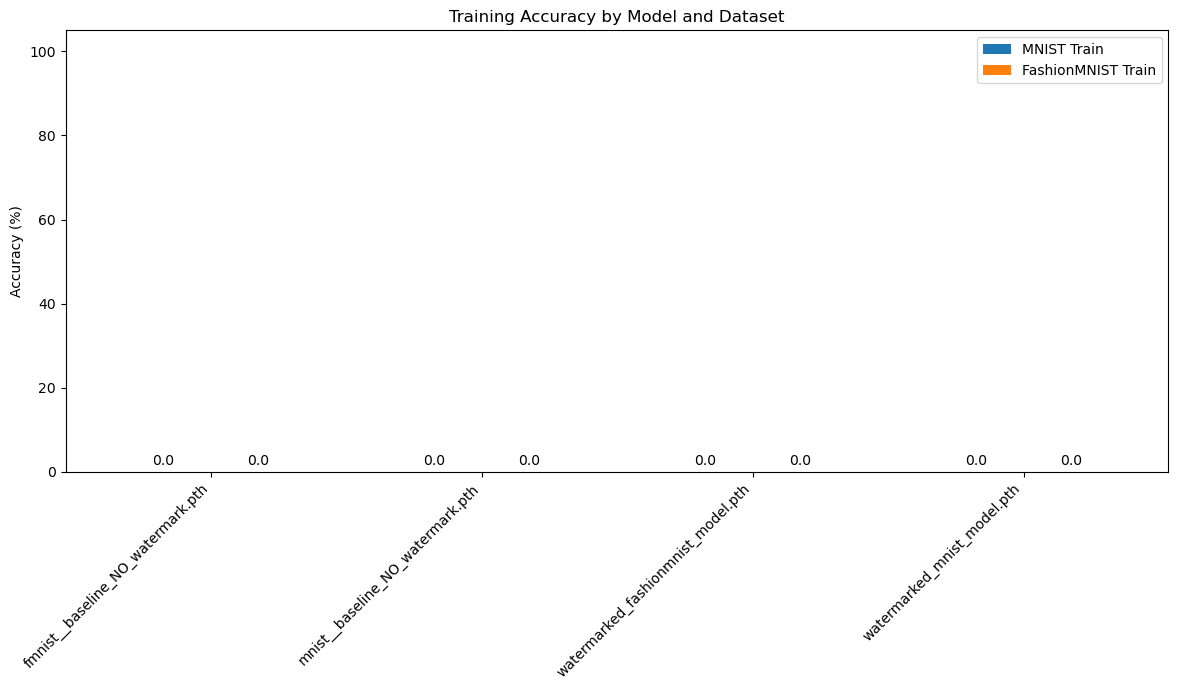

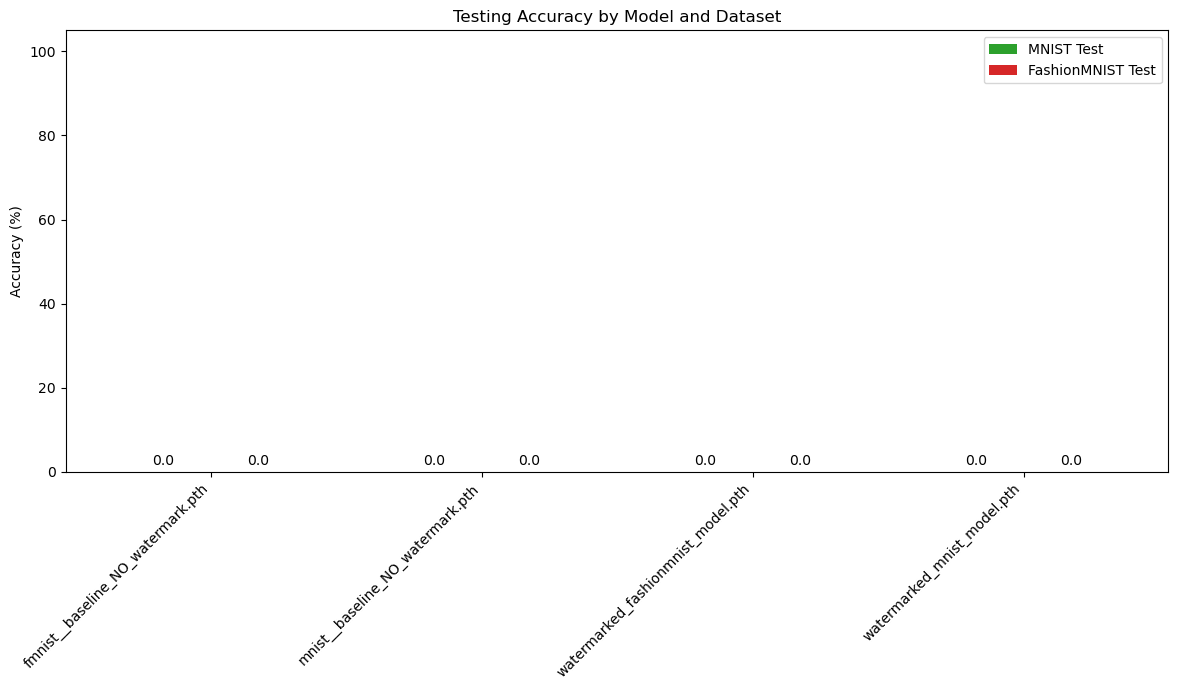

In [16]:
print(os.getcwd())
results = evaluate_and_plot_model_performance(model_dir="models", dataloaders_dict=dataloaders)